In [458]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [459]:
import numpy as np

def fill_nans_with_neighbor_mean(Z: np.ndarray, iters: int = 10, use_diagonals: bool = True) -> np.ndarray:
    """
    Iteratively fill NaNs with the mean of neighbouring cells.
    - iters: more iterations fills larger holes.
    - use_diagonals: True = 8-neighbourhood, False = 4-neighbourhood.
    """
    Z = Z.astype(float, copy=True)

    for _ in range(iters):
        nan_mask = np.isnan(Z)
        if not nan_mask.any():
            break

        Z_new = Z.copy()

        for i, j in np.argwhere(nan_mask):
            vals = []

            # 4-neighbours
            if i > 0: vals.append(Z[i - 1, j])
            if i < Z.shape[0] - 1: vals.append(Z[i + 1, j])
            if j > 0: vals.append(Z[i, j - 1])
            if j < Z.shape[1] - 1: vals.append(Z[i, j + 1])

            # diagonals
            if use_diagonals:
                if i > 0 and j > 0: vals.append(Z[i - 1, j - 1])
                if i > 0 and j < Z.shape[1] - 1: vals.append(Z[i - 1, j + 1])
                if i < Z.shape[0] - 1 and j > 0: vals.append(Z[i + 1, j - 1])
                if i < Z.shape[0] - 1 and j < Z.shape[1] - 1: vals.append(Z[i + 1, j + 1])

            vals = [v for v in vals if not np.isnan(v)]
            if vals:
                Z_new[i, j] = float(np.mean(vals))

        # stop if we couldn't fill anything this pass
        if np.array_equal(Z_new, Z):
            break

        Z = Z_new

    return Z


In [460]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def plot_policy_heatmap(
    df: pd.DataFrame,
    over_min: int,
    over_max: int,
    title: str = "Policy heatmap",
    run_bin_size: int = 10,
    tau: float = 0.1,
    plot: str = "expected_action",   # "attack_prob" | "neutral_prob" | "defend_prob" | "expected_action"
    wicket_min: int = 0,
    wicket_max: int = 10,
):
    actions = ["Defend", "Neutral", "Attack"]

    sub = df[df["over"].between(over_min, over_max)].copy()
    if sub.empty:
        raise ValueError("No rows in selected over range")

    # --- bin runs ---
    sub["run_bin"] = (sub["runs"].astype(int) // run_bin_size) * run_bin_size

    # --- aggregate Q per (wickets, run_bin) ---
    q = (
        sub.groupby(["wickets", "run_bin"])[actions]
        .mean()
        .reset_index()
    )

    # --- softmax per cell ---
    Q = q[actions].to_numpy(float)
    Q = Q / max(tau, 1e-12)
    Q = Q - Q.max(axis=1, keepdims=True)
    P = np.exp(Q)
    P = P / P.sum(axis=1, keepdims=True)

    if plot == "attack_prob":
        q["value"] = P[:, 2]
        vmin, vmax = 0, 1
        cbar_label = "P(Attack)"
        cmap = sns.color_palette("Reds", as_cmap=True)

    elif plot == "neutral_prob":
        q["value"] = P[:, 1]
        vmin, vmax = 0, 1
        cbar_label = "P(Neutral)"
        cmap = sns.color_palette("Oranges", as_cmap=True)

    elif plot == "defend_prob":
        q["value"] = P[:, 0]
        vmin, vmax = 0, 1
        cbar_label = "P(Defend)"
        cmap = sns.color_palette("Blues", as_cmap=True)

    elif plot == "expected_action":
        q["value"] = P @ np.array([0.0, 1.0, 2.0])
        vmin, vmax = 0, 2
        cbar_label = "Expected action (0=Defend, 1=Neutral, 2=Attack)"

        cmap = sns.color_palette("RdYlBu_r", as_cmap=True)
    else:
        raise ValueError("plot must be: attack_prob, neutral_prob, defend_prob, expected_action")

    # --- grid ---
    grid = q.pivot(index="wickets", columns="run_bin", values="value")

    # force full wicket range
    grid = grid.reindex(range(wicket_min, wicket_max + 1))

    # force contiguous run bins + smooth gaps
    run_bins = np.arange(
        int(sub["run_bin"].min()),
        int(sub["run_bin"].max()) + run_bin_size,
        run_bin_size
    )
    grid = (
        grid
        .reindex(columns=run_bins)
    )

    Z = grid.to_numpy()
    Z = fill_nans_with_neighbor_mean(Z, iters=20, use_diagonals=True)

    # --- plot ---
    plt.figure(figsize=(11, 6))

    plt.imshow(
        Z,
        origin="lower",
        aspect="auto",
        interpolation="bilinear",  # <-- real smoothing
        vmin=vmin,
        cmap=cmap,
        vmax=vmax
    )

    cbar = plt.colorbar()
    cbar.set_label(cbar_label)

    plt.title(f"{title} (overs {over_min}–{over_max}, bin={run_bin_size}, tau={tau})")
    plt.xlabel("Runs (binned)")
    plt.ylabel("Wickets")

    plt.xticks(np.arange(len(grid.columns)), grid.columns.astype(int), rotation=90)
    plt.yticks(np.arange(len(grid.index)), grid.index)

    plt.tight_layout()
    plt.show()


In [461]:

def plot_temperature(temperature, agent):
    path = f"../data/temperature-{temperature}/{agent}/"
    policy_table = joblib.load(f"{path}q_table.joblib")
    policy_df = (
        pd.Series(policy_table)
        .rename_axis(["k0", "k1", "k2"])
        .apply(pd.Series)
        .reset_index()
    )

    policy_df.columns = ["over", "runs", "wickets", "Attack", "Neutral", "Defend"]

    hist = joblib.load(f"{path}q_updates.joblib")
    abs_update_history = hist["abs_update_history"]
    t, du = zip(*abs_update_history)

    # smooth with rolling mean
    window = 20000
    smooth = np.convolve(du, np.ones(window)/window, mode="valid")

    plt.figure(figsize=(8, 4))
    plt.plot(smooth)
    plt.xlabel("Update step")
    plt.ylabel("Mean |ΔQ|")
    plt.title(f"{agent} agent, temperature {temperature}: mean absolute Q-update size")
    plt.tight_layout()
    plt.show()

    # Powerplay
    plot_policy_heatmap(policy_df, over_min=1, over_max=6, tau=temperature, title=f"{agent} policy heatmap, temperature {temperature}")

    # Middle overs
    plot_policy_heatmap(policy_df, over_min=7, over_max=15, tau=temperature, title=f"{agent} policy heatmap, temperature {temperature}")

    # Death overs
    plot_policy_heatmap(policy_df, over_min=16, over_max=20, tau=temperature, title=f"{agent} policy heatmap, temperature {temperature}")

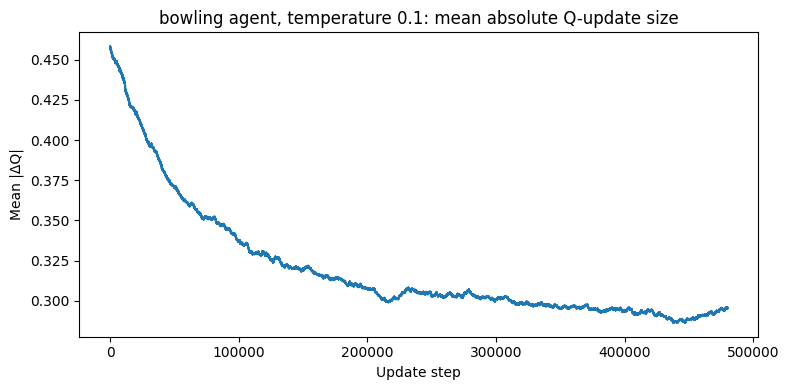

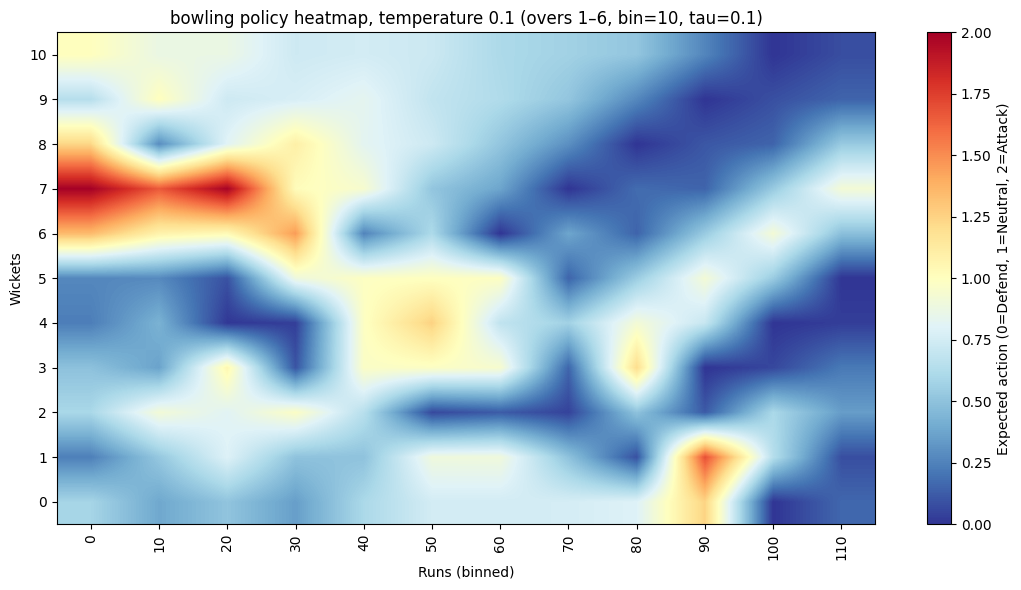

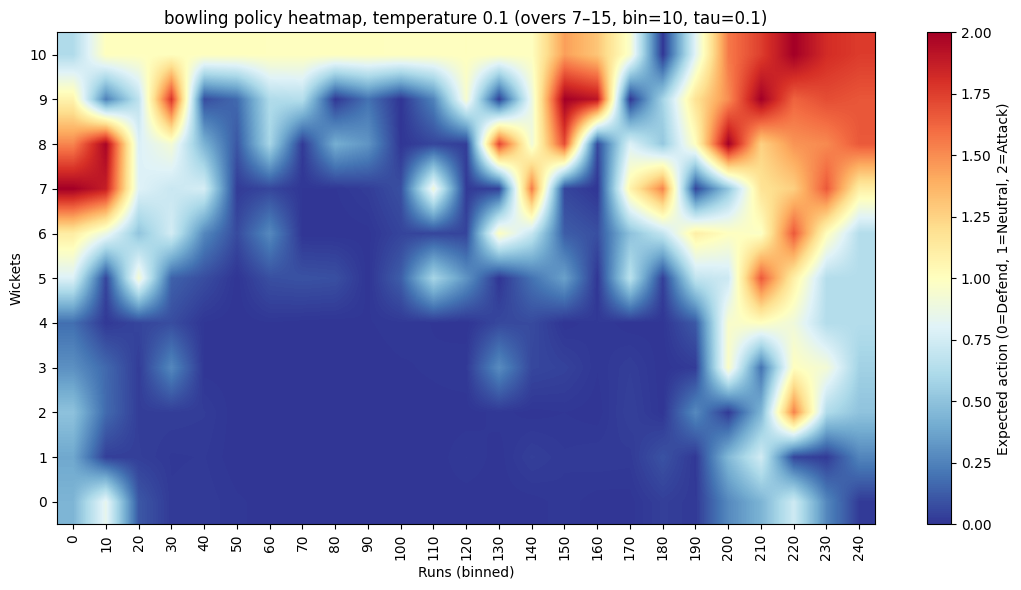

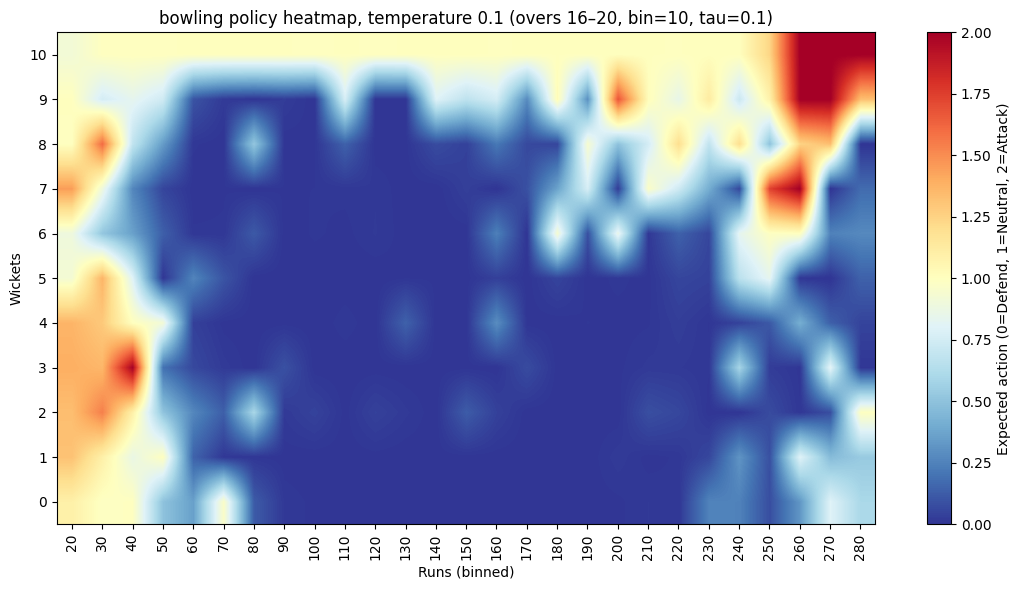

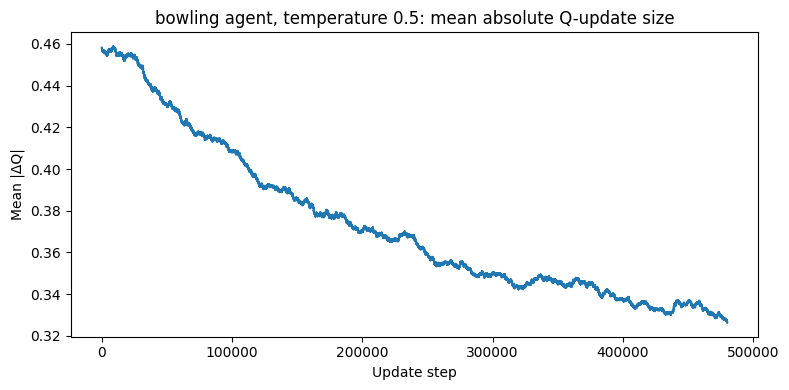

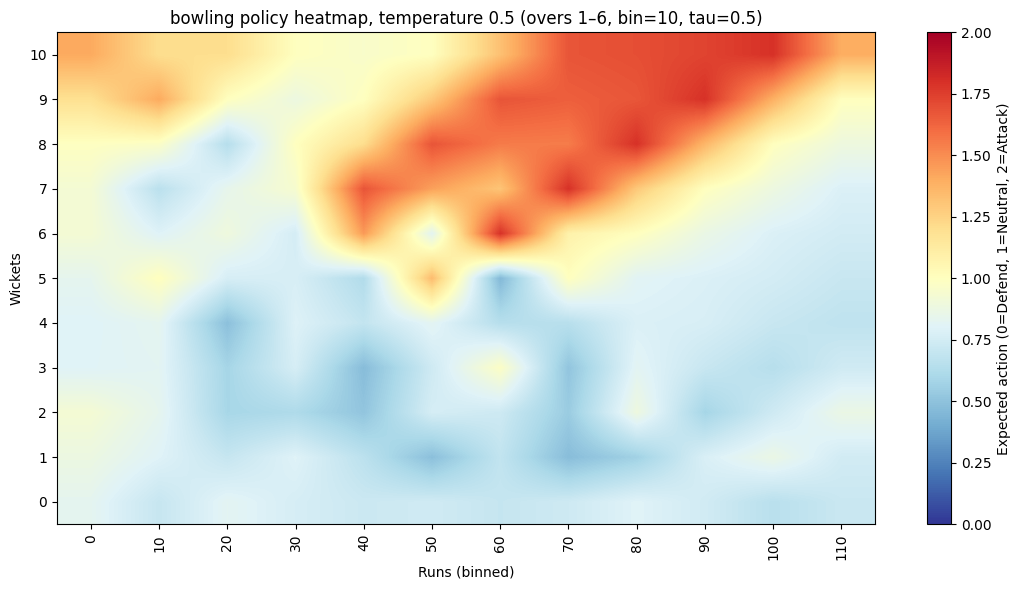

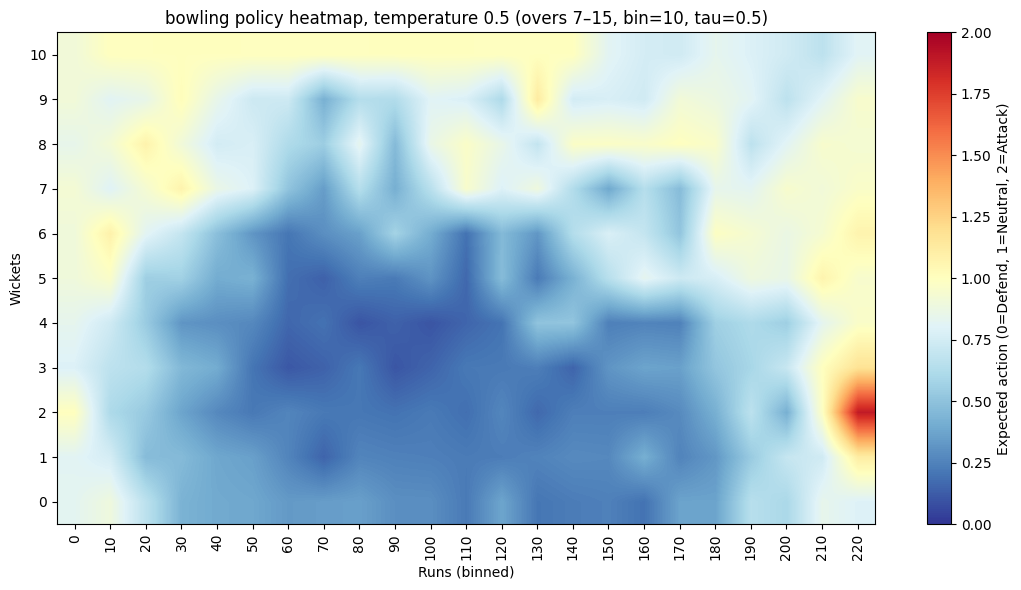

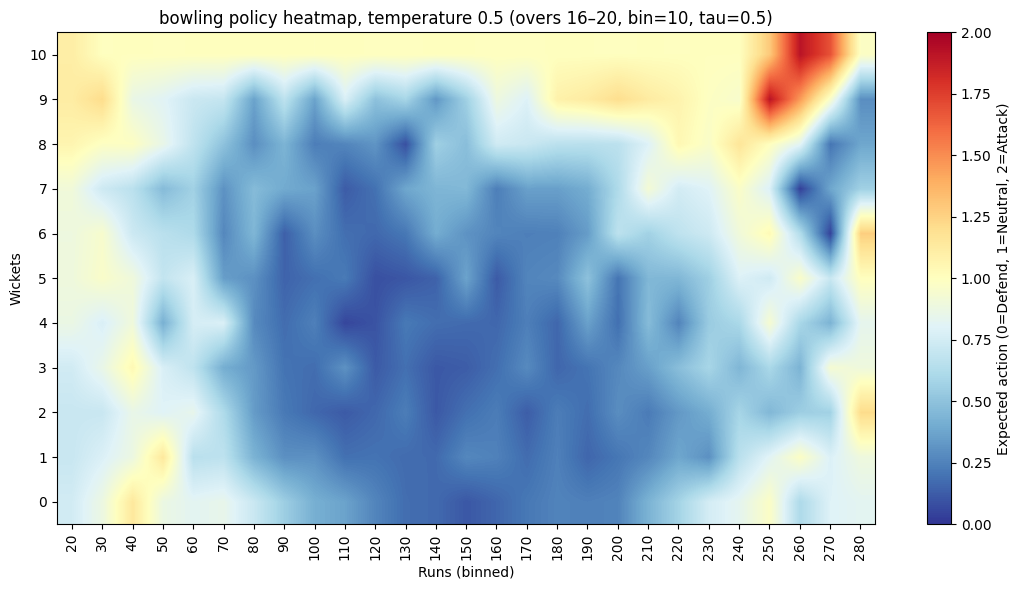

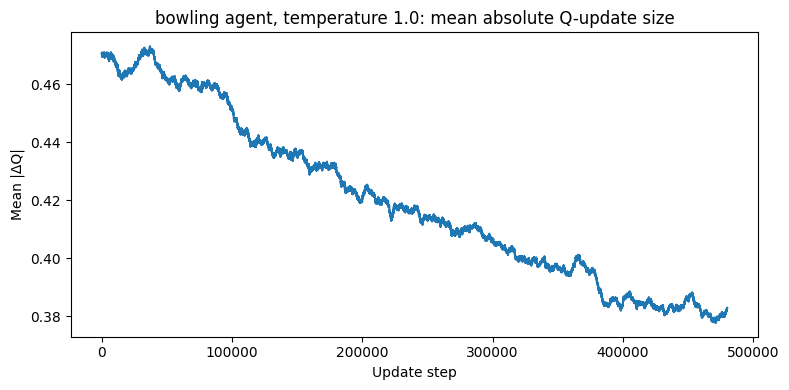

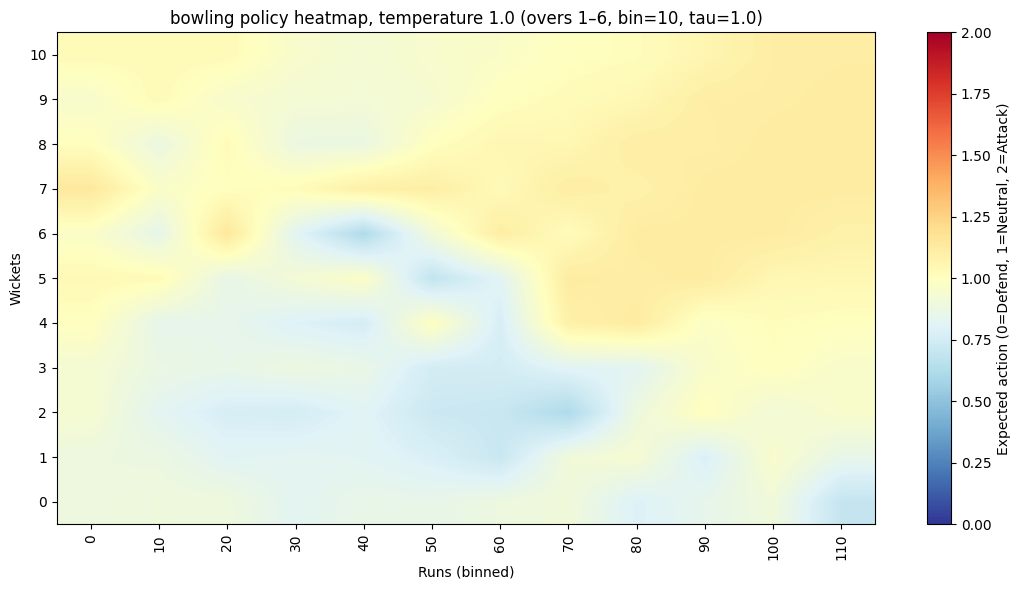

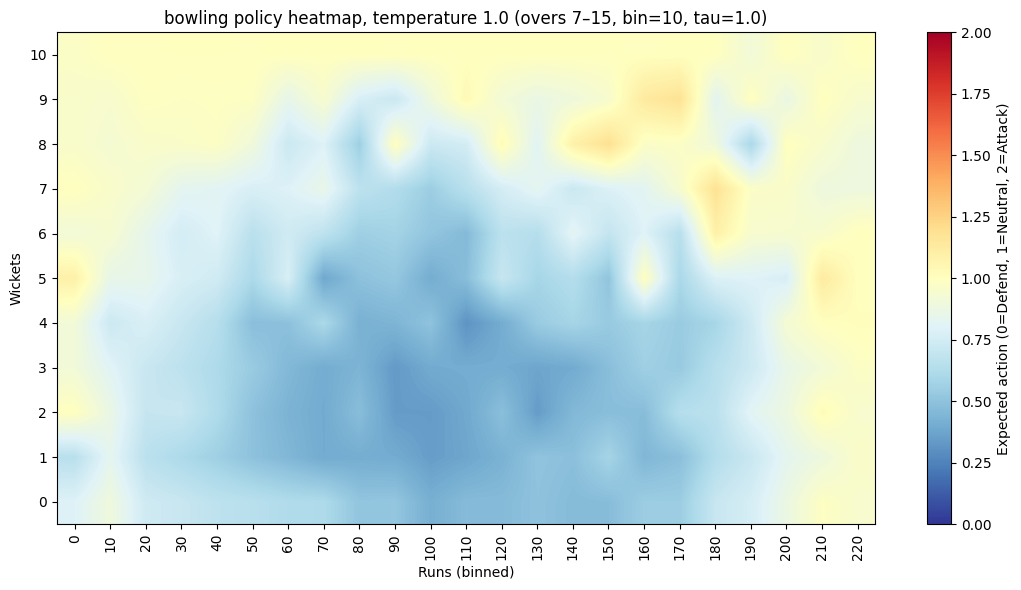

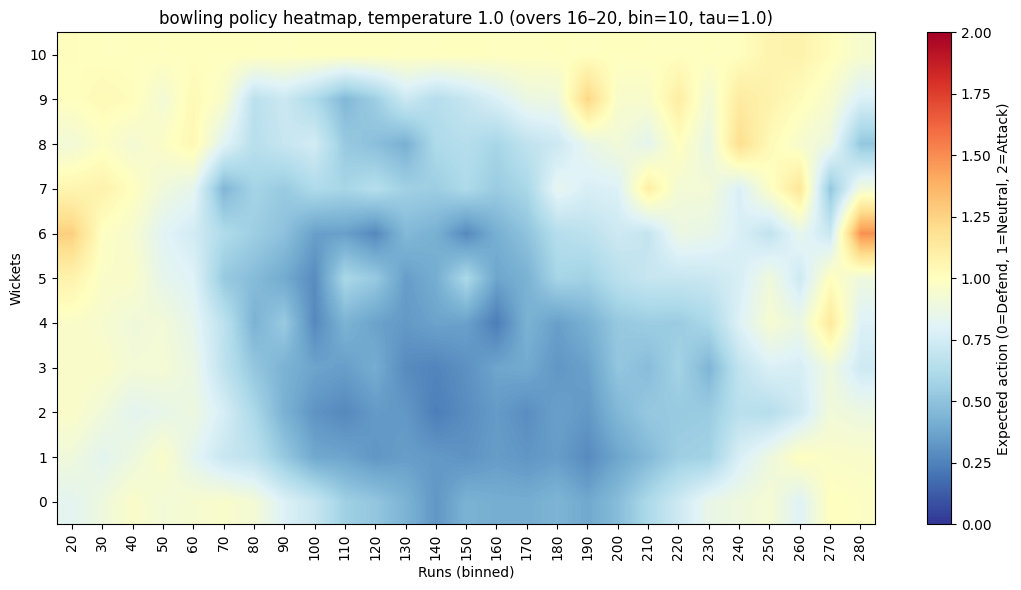

In [462]:
plot_temperature(0.1, "bowling")
plot_temperature(0.5, "bowling")
plot_temperature(1.0, "bowling")

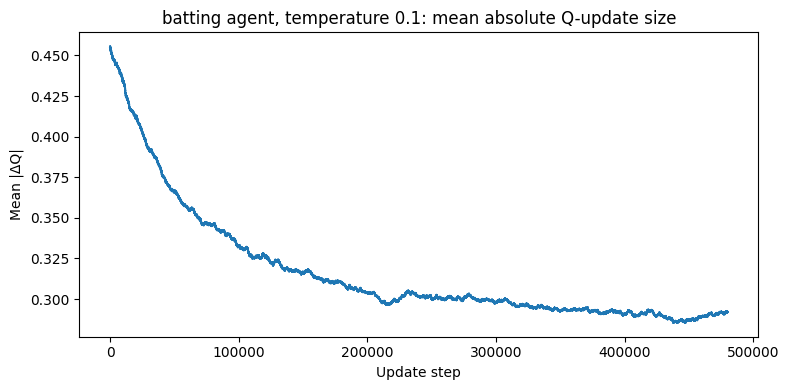

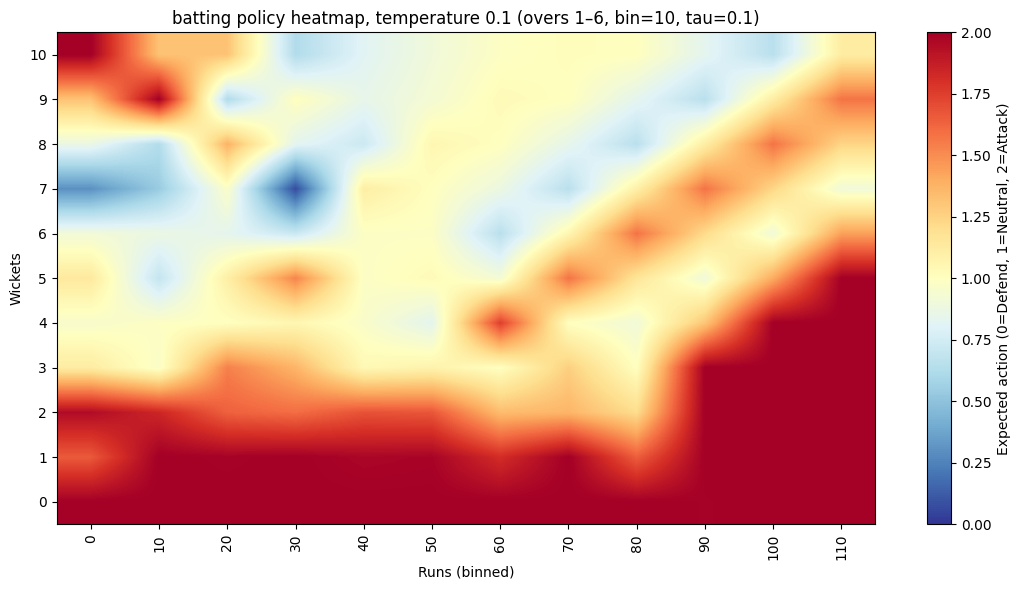

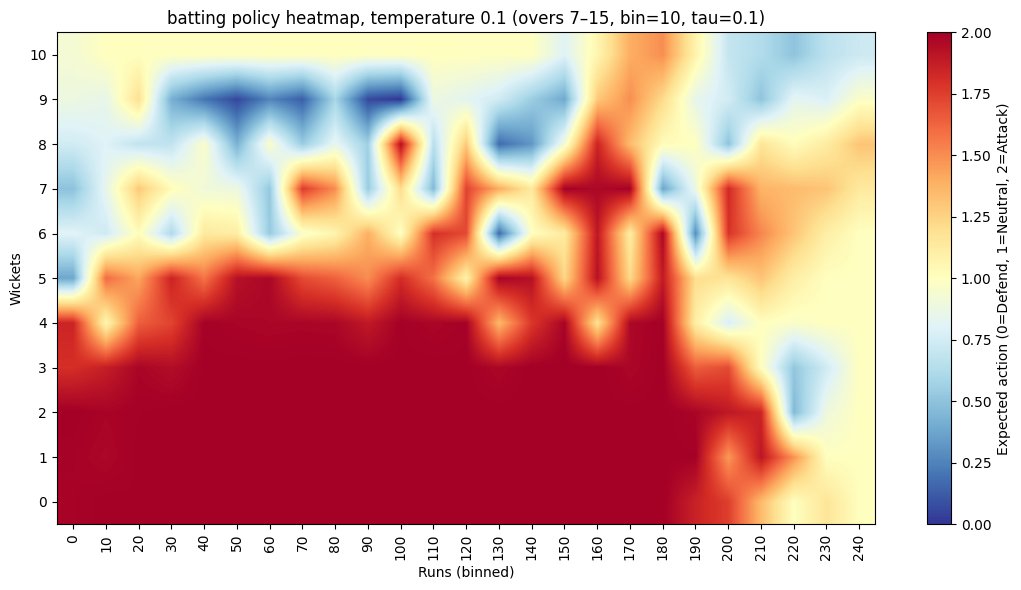

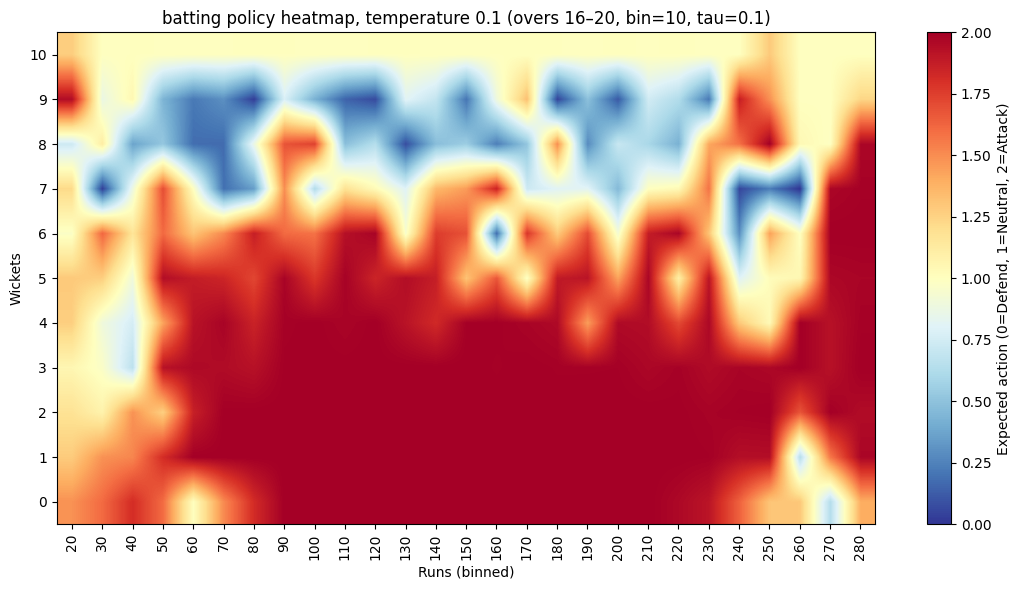

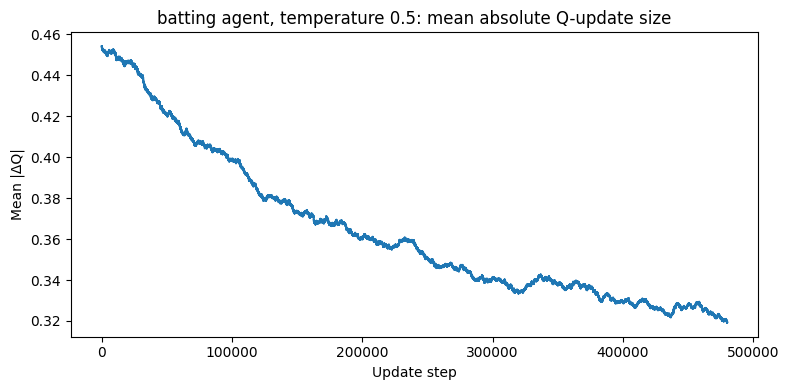

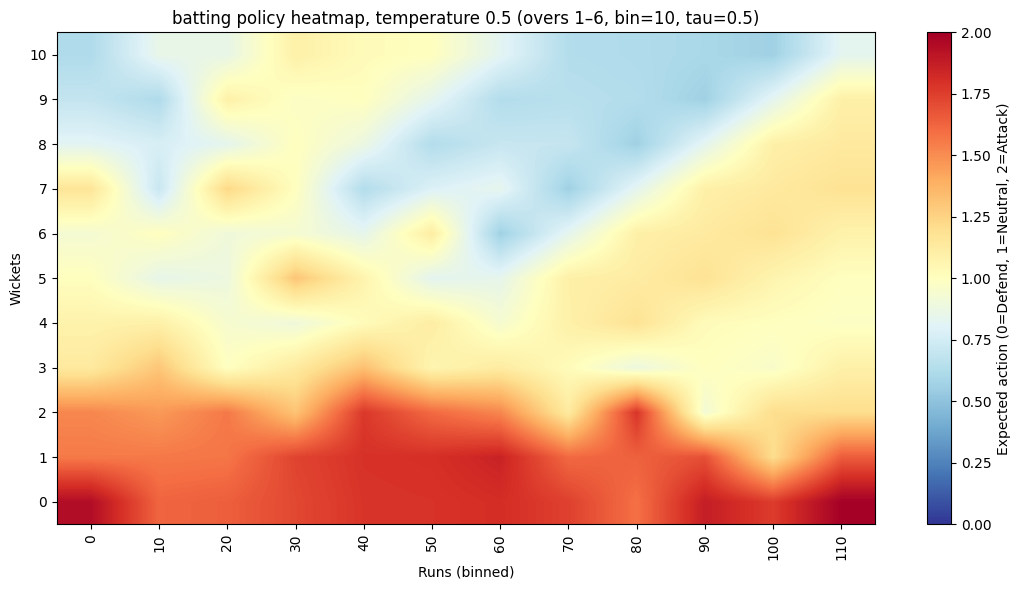

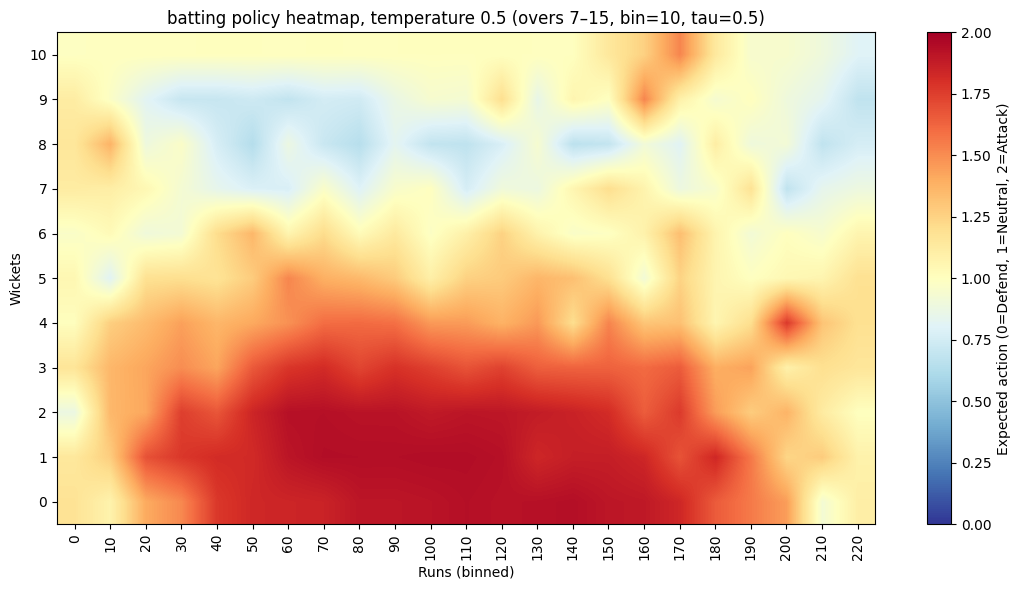

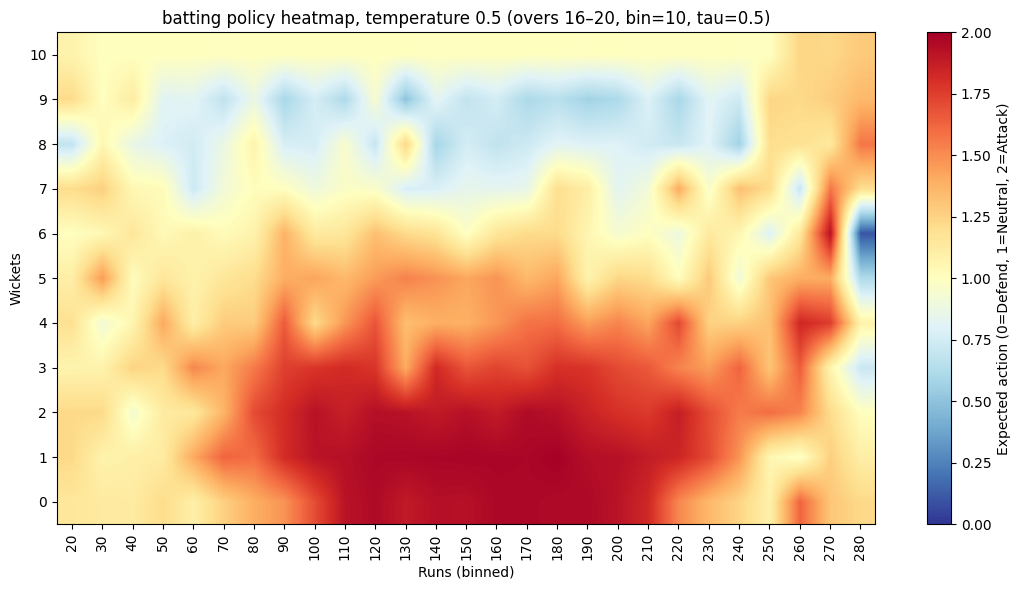

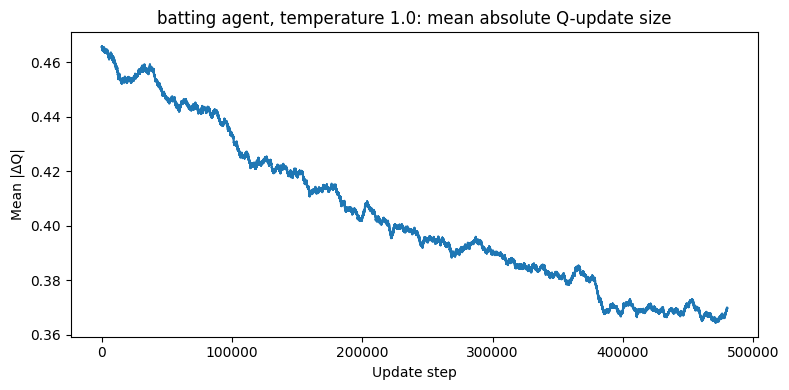

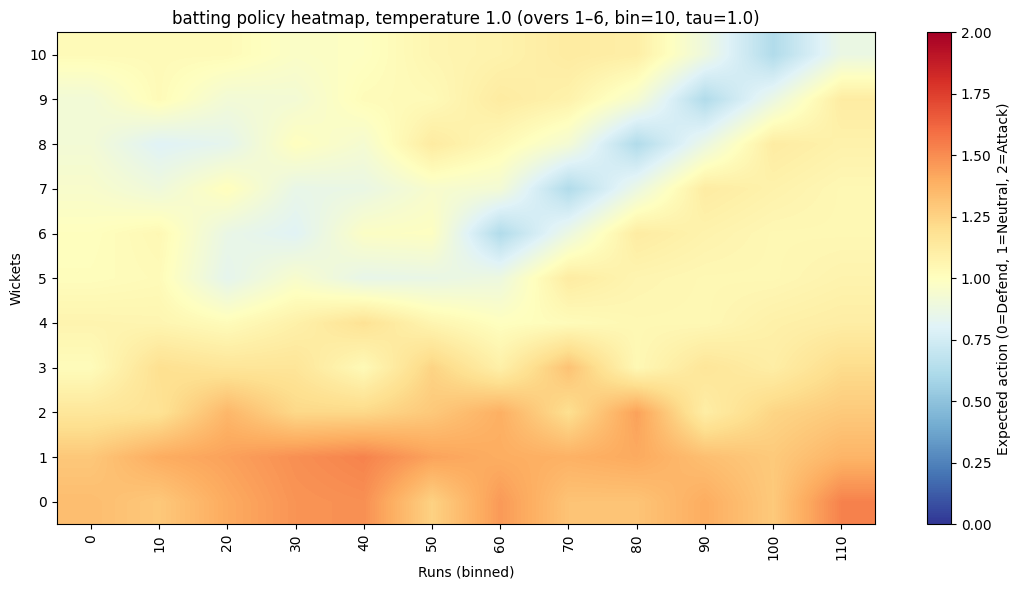

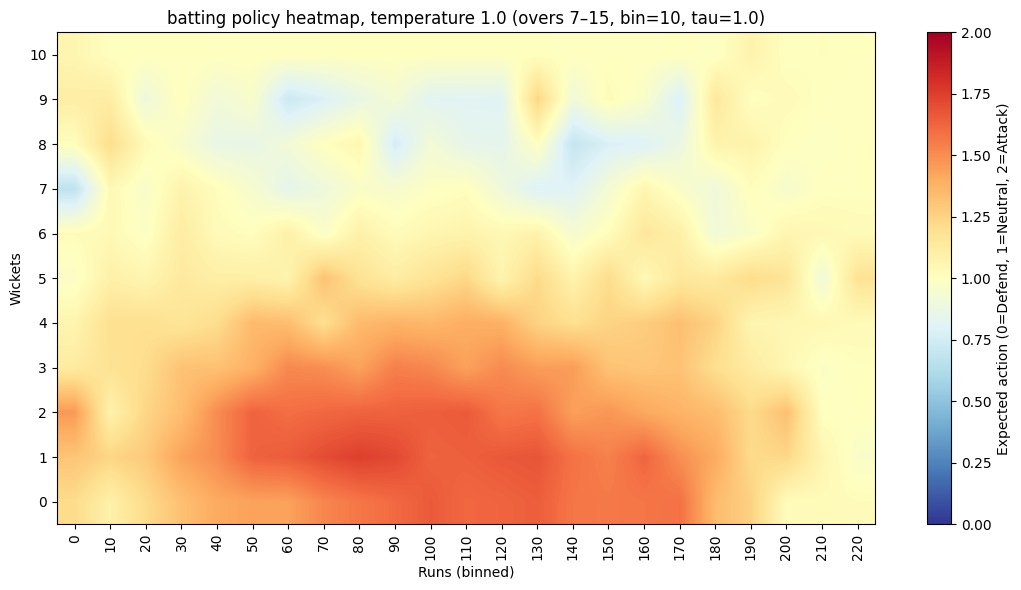

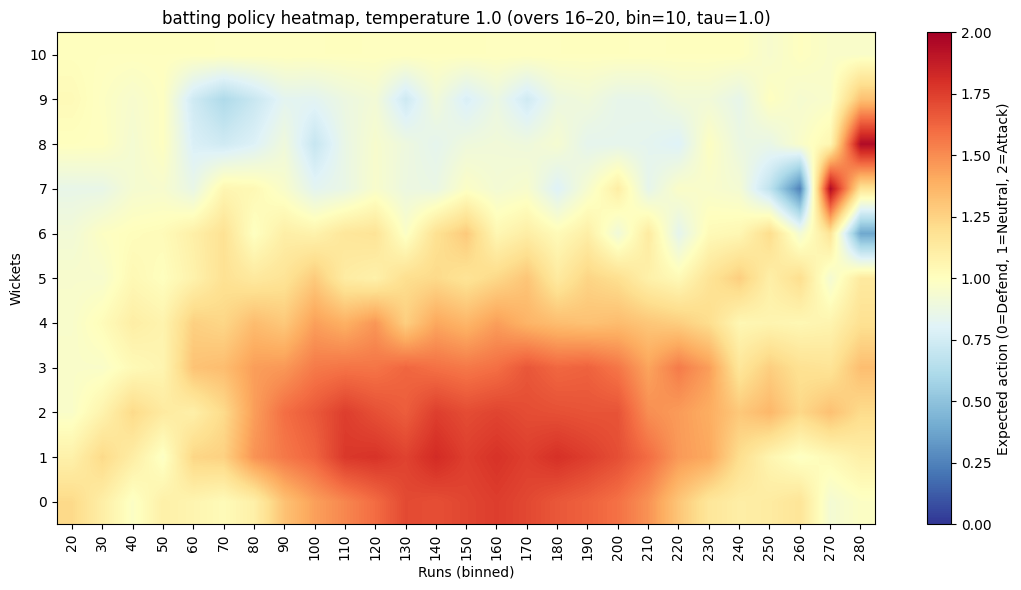

In [463]:
plot_temperature(0.1, "batting")
plot_temperature(0.5, "batting")
plot_temperature(1.0, "batting")

In [ ]:
def softmax_temp(logits: np.ndarray, tau: float, axis: int = -1) -> np.ndarray:
    """Softmax with temperature tau. logits shape (A,)."""
    logits = np.asarray(logits, dtype=float)
    if tau <= 0:
        raise ValueError("tau must be > 0")

    z = logits / tau
    z = z - np.max(z, axis=axis, keepdims=True)  # stability
    ez = np.exp(z)
    return ez / np.sum(ez, axis=axis, keepdims=True)

In [ ]:
path = "../data/temperature-0.1/batting/"
batting_policy_table = joblib.load(f"{path}q_table.joblib")

batting_policy_df = (
    pd.Series(batting_policy_table)
    .rename_axis(["k0", "k1", "k2"])
    .apply(pd.Series)
    .reset_index()
)

batting_policy_df.columns = ["over", "runs", "wickets", "Attack", "Neutral", "Defend"]
batting_policy_df[["Attack", "Neutral", "Defend"]] = softmax_temp(batting_policy_df[["Attack", "Neutral", "Defend"]], 0.1)

In [440]:
def expected_reward(expected_overs, expected_runs, expected_wickets, bat_action, bowl_action):
    runs_mean_matrix = np.array([
        [15.0, 11.0, 8.0],
        [11.0,  8.0, 5.0],
        [ 8.0,  5.0, 3.0]
    ])

    wkts_mean_matrix = np.array([
        [1.00, 1.0, 0.34],
        [1.0, 0.34, 0.00],
        [0.34, 0.00, 0.00]
    ])

    prev_run_potential = expected_runs - expected_wickets**2 - 7*expected_overs + 164
    new_run_potential = (expected_runs + runs_mean_matrix[bat_action][bowl_action]) - (expected_wickets + wkts_mean_matrix[bat_action][bowl_action])**2 - 7*(expected_overs + 1) + 164

    return (new_run_potential - prev_run_potential)

In [ ]:
path = "../data/temperature-0.1/bowling/"
bowling_policy_table = joblib.load(f"{path}q_table.joblib")

bowling_policy_df = (
    pd.Series(bowling_policy_table)
    .rename_axis(["k0", "k1", "k2"])
    .apply(pd.Series)
    .reset_index()
)

bowling_policy_df.columns = ["over", "runs", "wickets", "Attack", "Neutral", "Defend"]
bowling_policy_df[["Attack", "Neutral", "Defend"]] = softmax_temp(bowling_policy_df[["Attack", "Neutral", "Defend"]], 0.1)

In [ ]:
path = "../data/temperature-0.1/batting/"
h = joblib.load(f"{path}q_history.joblib")

In [443]:
key_max = max(h, key=lambda k: -1 if k[0] > 16 else len(h[k]))
key_max, len(h[key_max])


((16, 140, 3), 110)

In [444]:
batting_policy_df

,over,runs,wickets,Attack,Neutral,Defend
0,1,0,0,0.995413,0.002287,0.002300
1,2,15,0,0.208789,0.595104,0.196107
2,3,26,0,0.654880,0.312877,0.032243
3,4,28,0,0.997384,0.002216,0.000400
4,5,43,0,0.962231,0.017652,0.020117
...,...,...,...,...,...,...
25544,15,30,8,0.271038,0.458265,0.270697
25545,15,48,2,0.226927,0.545676,0.227397
25546,15,35,5,0.251093,0.374202,0.374705
25547,16,40,5,0.175089,0.413402,0.411509


In [445]:
bowling_policy_df

,over,runs,wickets,Attack,Neutral,Defend
0,1,0,0,0.019008,0.243986,0.737006
1,2,15,0,0.169083,0.645750,0.185167
2,3,26,0,0.087997,0.842170,0.069834
3,4,28,0,0.008135,0.766286,0.225579
4,5,43,0,0.628289,0.134049,0.237663
...,...,...,...,...,...,...
25544,15,30,8,0.360621,0.278389,0.360990
25545,15,48,2,0.399225,0.200922,0.399853
25546,15,35,5,0.286129,0.286485,0.427385
25547,16,40,5,0.596334,0.201918,0.201748


In [ ]:
mask = batting_policy_df["over"].between(7, 15) & (batting_policy_df["runs"] < 90) & (batting_policy_df["wickets"] < 4)

batting_powerplay_strategy = batting_policy_df[mask].mean()

In [447]:
bowling_powerplay_strategy = bowling_policy_df[mask].mean()

In [448]:
batting_powerplay_strategy, bowling_powerplay_strategy

(over        20.000000
 runs       161.127099
 wickets      5.202905
 Attack       0.478119
 Neutral      0.305911
 Defend       0.215970
 dtype: float64,
 over        20.000000
 runs       161.127099
 wickets      5.202905
 Attack       0.169143
 Neutral      0.301149
 Defend       0.529708
 dtype: float64)

In [449]:
expected_overs = batting_powerplay_strategy["over"]
expected_runs = batting_powerplay_strategy["runs"]
expected_wickets = batting_powerplay_strategy["wickets"]

expected_payoff = np.zeros(shape=(3, 3))

for i in range(0, 3):
    for j in range(0, 3):
        expected_payoff[i][j] = expected_reward(expected_overs, expected_runs, expected_wickets, i, j)

In [450]:
batter_expected_payoff = expected_payoff
bowler_expected_payoff = -batter_expected_payoff

In [451]:
x = batting_powerplay_strategy[["Attack", "Neutral", "Defend"]]
y = bowling_powerplay_strategy[["Attack", "Neutral", "Defend"]]

In [452]:
x, y

(Attack     0.478119
 Neutral    0.305911
 Defend     0.215970
 dtype: float64,
 Attack     0.169143
 Neutral    0.301149
 Defend     0.529708
 dtype: float64)

In [453]:
batter_expected_payoff

array([[-3.40581026, -7.40581026, -2.65357549],
       [-7.40581026, -2.65357549, -2.        ],
       [-2.65357549, -2.        , -4.        ]])

In [454]:
def softmax_t(x: np.ndarray, tau: float) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    z = x / tau
    z = z - np.max(z)        # subtract max for numerical stability
    ez = np.exp(z)
    return ez / ez.sum()

In [455]:
softmax_t(batter_expected_payoff @ y, 0.5)

array([0.05532512, 0.50007292, 0.44460196])

In [456]:
softmax_t(bowler_expected_payoff.T @ x, 0.5)

array([0.3425646, 0.6465074, 0.010928 ])